## Read data matrix

In [80]:
import pandas as pd
import psycopg2

# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'omop_cdm'

# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

In [12]:
dataQuery = """select * from sepsis_micro.data_matrix_1;"""
dataDf = pd.read_sql_query(dataQuery, con)
dataDf

,micro_specimen_id,person_id,visit_occurrence_concept_name,visit_duration_hrs,visit_source_concept_name,admitting_source_value,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,...,hemoglobin_last,creatinine_last,time_to_antibiotic,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality
0,2940,-470494077,Emergency Room - Hospital,708.0,EW EMER.,TRANSFER FROM HOSPITAL,99.9,92.0,26.0,37.0,...,8.0,1.6,0.0,False,False,False,True,True,True,True
1,3236,-762840899,Emergency Room - Hospital,1807.0,EW EMER.,EMERGENCY ROOM,100.0,89.0,18.0,18.0,...,7.7,3.1,0.0,False,True,True,True,True,True,True
2,3720,-1481508426,Emergency Room and Inpatient Visit,94.0,URGENT,TRANSFER FROM HOSPITAL,98.3,117.0,NaN,NaN,...,8.8,1.3,8.0,False,False,False,False,False,False,False
3,5214,2090709572,Observation Room,197.0,OBSERVATION ADMIT,EMERGENCY ROOM,98.7,114.0,NaN,NaN,...,8.3,1.0,-2729.0,False,False,False,False,False,False,False
4,10611,-961491032,Emergency Room - Hospital,1335.0,EW EMER.,EMERGENCY ROOM,98.5,134.0,24.0,0.0,...,9.5,0.5,37.0,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,Emergency Room and Inpatient Visit,499.0,URGENT,TRANSFER FROM HOSPITAL,38.6,NaN,NaN,NaN,...,8.8,0.9,-4.0,False,False,False,False,False,False,False
7098,9989349,-1246337626,Emergency Room - Hospital,203.0,EW EMER.,EMERGENCY ROOM,99.8,89.0,12.0,23.0,...,10.2,4.3,31.0,False,False,False,False,False,False,False
7099,9989996,-1704051650,Emergency Room and Inpatient Visit,120.0,URGENT,TRANSFER FROM HOSPITAL,97.8,129.0,NaN,NaN,...,7.2,0.8,0.0,True,True,True,True,True,True,True
7100,9996881,768076701,Emergency Room - Hospital,887.0,EW EMER.,EMERGENCY ROOM,99.8,116.0,25.0,25.0,...,8.7,0.6,32.0,False,False,True,True,True,True,True


## Missing data

In [19]:
dataDf.isna().sum().sort_values()

micro_specimen_id               0
sixty_day_mortality             0
twentyeight_day_mortality       0
twentyone_day_mortality         0
fourteen_day_mortality          0
                             ... 
meanbp_first                 4753
meanbp_avg                   4753
sysbp_sd                     4754
meanbp_sd                    4762
breath_rate_vent_sd          4769
Length: 146, dtype: int64

<AxesSubplot:>

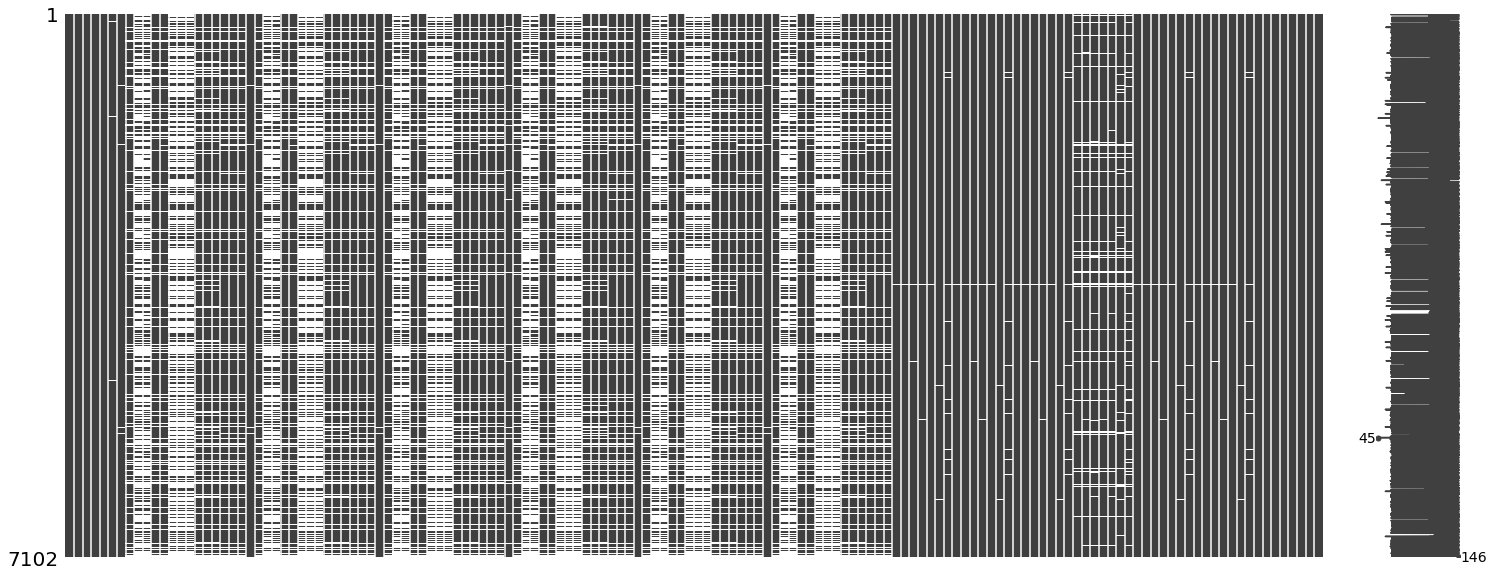

In [20]:
import missingno as msno

msno.matrix(dataDf)

<AxesSubplot:>

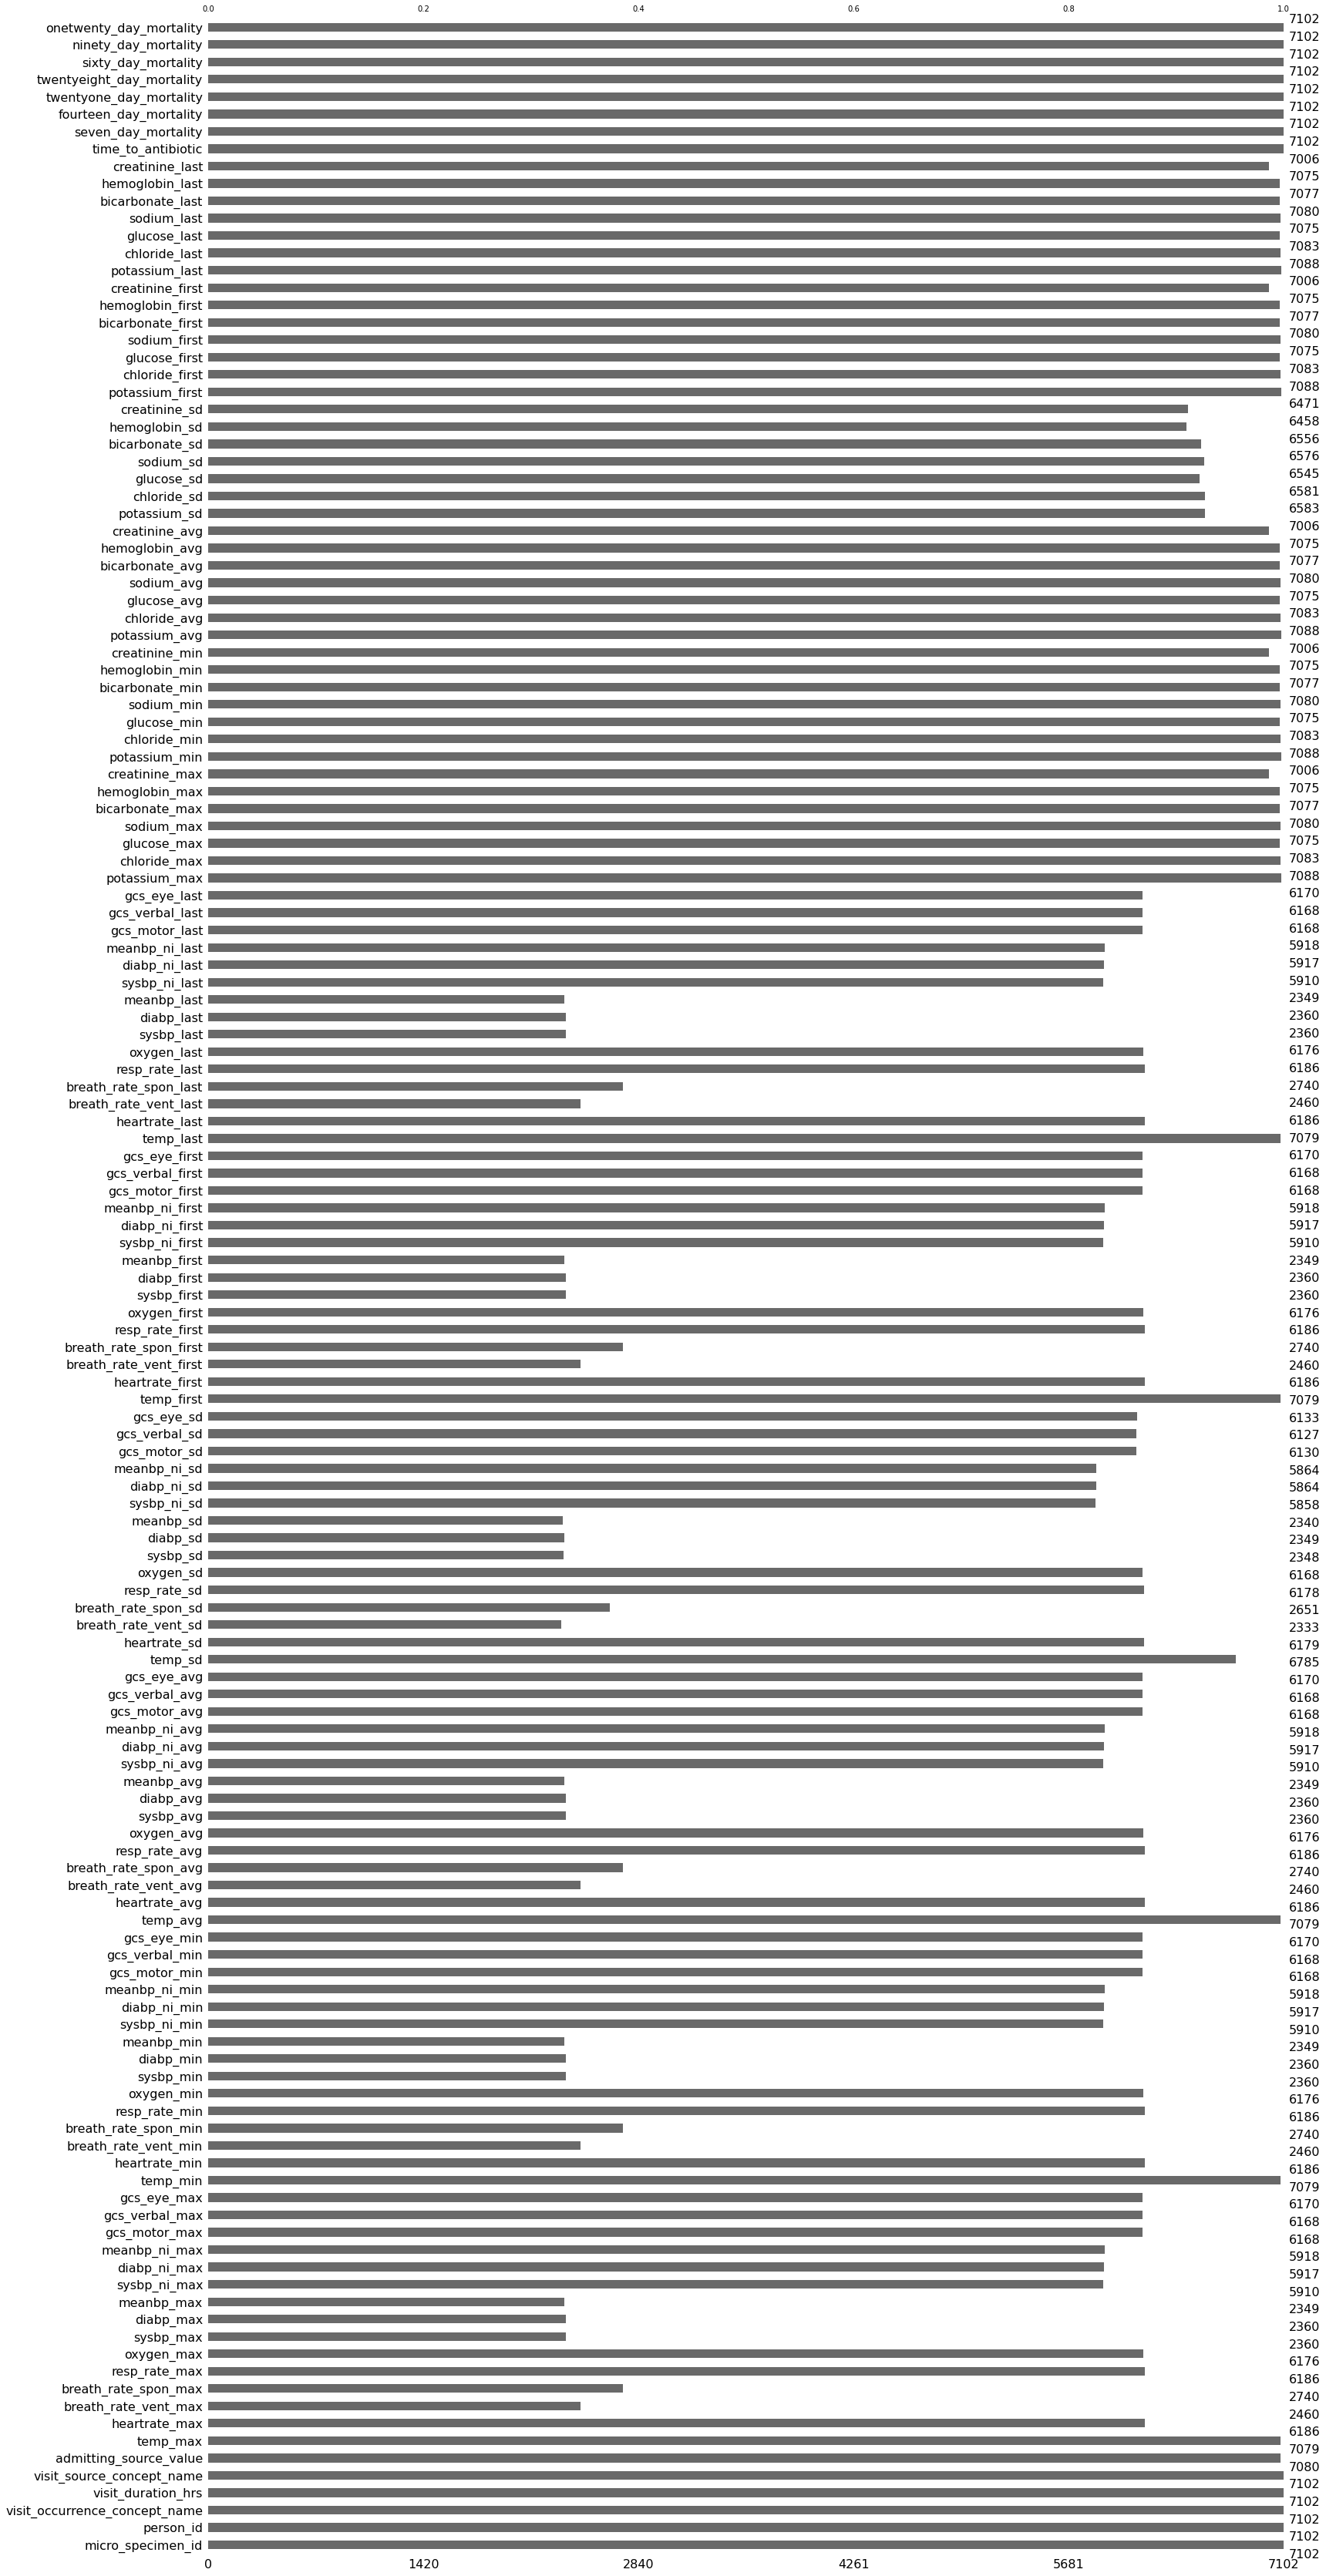

In [21]:
import missingno as msno

msno.bar(dataDf)

## One-hot-encode categorical columns

In [22]:
for catCol in ['visit_occurrence_concept_name', 'visit_source_concept_name', 'admitting_source_value']:
    dummyDf = pd.get_dummies(dataDf[catCol])
    dataDf.drop(catCol, axis = 1, inplace=True)
    dataDf = dataDf.join(dummyDf)
dataDf

,micro_specimen_id,person_id,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,...,CLINIC REFERRAL,EMERGENCY ROOM,INFORMATION NOT AVAILABLE,INTERNAL TRANSFER TO OR FROM PSYCH,PACU,PHYSICIAN REFERRAL,PROCEDURE SITE,TRANSFER FROM HOSPITAL,TRANSFER FROM SKILLED NURSING FACILITY,WALK-IN/SELF REFERRAL
0,2940,-470494077,708.0,99.9,92.0,26.0,37.0,37.0,100.0,139.0,...,0,0,0,0,0,0,0,1,0,0
1,3236,-762840899,1807.0,100.0,89.0,18.0,18.0,33.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0
2,3720,-1481508426,94.0,98.3,117.0,NaN,NaN,31.0,100.0,NaN,...,0,0,0,0,0,0,0,1,0,0
3,5214,2090709572,197.0,98.7,114.0,NaN,NaN,24.0,98.0,NaN,...,0,1,0,0,0,0,0,0,0,0
4,10611,-961491032,1335.0,98.5,134.0,24.0,0.0,27.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,499.0,38.6,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
7098,9989349,-1246337626,203.0,99.8,89.0,12.0,23.0,24.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0
7099,9989996,-1704051650,120.0,97.8,129.0,NaN,NaN,28.0,100.0,NaN,...,0,0,0,0,0,0,0,1,0,0
7100,9996881,768076701,887.0,99.8,116.0,25.0,25.0,31.0,100.0,NaN,...,0,1,0,0,0,0,0,0,0,0


## Standardise

In [23]:
cols = ["visit_duration_hrs", "temp_max", "heartrate_max", "breath_rate_vent_max", "breath_rate_spon_max", "resp_rate_max", "oxygen_max", "sysbp_max", "diabp_max", "meanbp_max", "sysbp_ni_max", "diabp_ni_max", "meanbp_ni_max", "gcs_motor_max", "gcs_verbal_max", "gcs_eye_max", "temp_min", "heartrate_min", "breath_rate_vent_min", "breath_rate_spon_min", "resp_rate_min", "oxygen_min", "sysbp_min", "diabp_min", "meanbp_min", "sysbp_ni_min", "diabp_ni_min", "meanbp_ni_min", "gcs_motor_min", "gcs_verbal_min", "gcs_eye_min", "temp_avg", "heartrate_avg", "breath_rate_vent_avg", "breath_rate_spon_avg", "resp_rate_avg", "oxygen_avg", "sysbp_avg", "diabp_avg", "meanbp_avg", "sysbp_ni_avg", "diabp_ni_avg", "meanbp_ni_avg", "gcs_motor_avg", "gcs_verbal_avg", "gcs_eye_avg", "temp_sd", "heartrate_sd", "breath_rate_vent_sd", "breath_rate_spon_sd", "resp_rate_sd", "oxygen_sd", "sysbp_sd", "diabp_sd", "meanbp_sd", "sysbp_ni_sd", "diabp_ni_sd", "meanbp_ni_sd", "gcs_motor_sd", "gcs_verbal_sd", "gcs_eye_sd", "temp_first", "heartrate_first", "breath_rate_vent_first", "breath_rate_spon_first", "resp_rate_first", "oxygen_first", "sysbp_first", "diabp_first", "meanbp_first", "sysbp_ni_first", "diabp_ni_first", "meanbp_ni_first", "gcs_motor_first", "gcs_verbal_first", "gcs_eye_first", "temp_last", "heartrate_last", "breath_rate_vent_last", "breath_rate_spon_last", "resp_rate_last", "oxygen_last", "sysbp_last", "diabp_last", "meanbp_last", "sysbp_ni_last", "diabp_ni_last", "meanbp_ni_last", "gcs_motor_last", "gcs_verbal_last", "gcs_eye_last", "potassium_max", "chloride_max", "glucose_max", "sodium_max", "bicarbonate_max", "hemoglobin_max", "creatinine_max", "potassium_min", "chloride_min", "glucose_min", "sodium_min", "bicarbonate_min", "hemoglobin_min", "creatinine_min", "potassium_avg", "chloride_avg", "glucose_avg", "sodium_avg", "bicarbonate_avg", "hemoglobin_avg", "creatinine_avg", "potassium_sd", "chloride_sd", "glucose_sd", "sodium_sd", "bicarbonate_sd", "hemoglobin_sd", "creatinine_sd", "potassium_first", "chloride_first", "glucose_first", "sodium_first", "bicarbonate_first", "hemoglobin_first", "creatinine_first", "potassium_last", "chloride_last", "glucose_last", "sodium_last", "bicarbonate_last", "hemoglobin_last", "creatinine_last", "time_to_antibiotic"]

In [24]:
from sklearn.preprocessing import StandardScaler

data = StandardScaler().fit_transform(dataDf[cols])
standardDf = pd.DataFrame(data, columns = cols)
standardDf

,visit_duration_hrs,temp_max,heartrate_max,breath_rate_vent_max,breath_rate_spon_max,resp_rate_max,oxygen_max,sysbp_max,diabp_max,meanbp_max,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,0.269967,0.389389,-1.142471,0.877938,1.304686,1.042698,0.391121,-0.353225,-0.535850,-0.893428,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,1.583718,0.393904,-1.290038,-0.447048,-0.160159,0.322355,0.391121,NaN,NaN,NaN,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,-0.464013,0.317148,0.087254,NaN,NaN,-0.037816,0.391121,NaN,NaN,NaN,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,-0.340886,0.335208,-0.060313,NaN,NaN,-1.298416,-1.795899,NaN,NaN,NaN,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,1.019486,0.326178,0.923466,0.546691,-1.547908,-0.758159,0.391121,NaN,NaN,NaN,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.020127,-2.378352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,-0.333714,0.384874,-1.290038,-1.440787,0.225326,-1.298416,0.391121,NaN,NaN,NaN,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,-0.432932,0.294573,0.677521,NaN,NaN,-0.578073,0.391121,NaN,NaN,NaN,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,0.483944,0.384874,0.038065,0.712314,0.379520,-0.037816,0.391121,NaN,NaN,NaN,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [25]:
dataDf = dataDf.drop(cols, axis = 1).join(standardDf)
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,False,False,False,True,True,True,True,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,False,True,True,True,True,True,True,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,False,False,False,False,False,False,False,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,False,False,False,False,False,False,False,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,False,False,False,False,False,False,False,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,False,False,False,False,False,False,False,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,False,False,False,False,False,False,False,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,True,True,True,True,True,True,True,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,False,False,True,True,True,True,True,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [26]:
dataDf['seven_day_mortality'] = dataDf['seven_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['fourteen_day_mortality'] = dataDf['fourteen_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['twentyone_day_mortality'] = dataDf['twentyone_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['twentyeight_day_mortality'] = dataDf['twentyeight_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['sixty_day_mortality'] = dataDf['sixty_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['ninety_day_mortality'] = dataDf['ninety_day_mortality'].apply(lambda x: 1 if x else 0)
dataDf['onetwenty_day_mortality'] = dataDf['onetwenty_day_mortality'].apply(lambda x: 1 if x else 0)

In [27]:
dataDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [28]:
import os

outPath = os.getcwd() + '/data/data_matrix_no_qc.csv'
dataDf.to_csv(outPath)

## Missing data imputation

### Import libraries

In [29]:
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import impyute as impy
import miceforest as mf
from statsmodels.multivariate.pca import PCA
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA as sklearnPCA
from MissForest import MissForest
# import datawig

### Obtain rows with no null values

In [30]:
fullDf = dataDf.drop(['micro_specimen_id', 'person_id'], axis = 1).dropna()

In [31]:
fullDf.shape

(1325, 166)

In [32]:
fullDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
6,1,1,1,1,1,1,1,0,0,1,...,0.634151,1.605033,0.985214,-0.065021,-0.943941,1.089014,-1.289310,-1.878499,0.491132,0.016301
7,0,0,0,0,0,0,0,0,0,1,...,-0.433813,0.211687,-1.265029,1.858215,-1.537974,0.900080,-1.480432,-0.857543,-0.148620,0.034467
8,0,0,0,0,1,1,1,0,0,0,...,-0.993222,-0.833323,0.119736,-0.952668,-0.851123,-1.178197,0.621905,-0.917599,-0.646204,0.022494
15,0,0,1,1,1,1,1,0,0,1,...,-0.332102,-0.554654,-0.399551,0.822626,0.114181,1.277948,-0.715946,-1.638274,0.206798,0.020017
16,1,1,1,1,1,1,1,0,0,1,...,-2.824017,-0.693988,-1.091934,-1.248550,-0.034327,-0.800329,-0.715946,0.043300,1.344134,0.019604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,1,1,1,1,1,1,1,0,0,0,...,-1.400066,2.301707,0.292832,-0.952668,0.782468,-0.989263,-0.524824,-0.857543,1.344134,0.018778
7064,0,0,0,0,0,0,0,0,0,1,...,1.346127,-0.275984,0.292832,0.082921,-0.925377,-0.233526,0.048541,0.523749,-0.006453,0.021255
7075,1,1,1,1,1,1,1,0,0,0,...,-0.789801,-0.345652,0.812119,-0.656785,-0.981068,-0.422460,0.239662,-0.617318,-0.148620,0.020017
7092,1,1,1,1,1,1,1,0,0,1,...,-0.128680,-0.833323,-0.918838,0.230862,-0.479852,0.711145,0.430784,0.583806,-0.504037,0.018778


### Create missingness

In [33]:
mask = np.random.choice(a=[True, False], size=fullDf.shape, p=[0.1, 0.9])
missingDf = fullDf.mask(mask)

In [34]:
missingDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,1.0,...,0.634151,1.605033,0.985214,-0.065021,-0.943941,1.089014,-1.289310,-1.878499,0.491132,0.016301
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,0.211687,-1.265029,1.858215,-1.537974,0.900080,-1.480432,-0.857543,-0.148620,0.034467
8,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.993222,-0.833323,NaN,-0.952668,-0.851123,-1.178197,0.621905,-0.917599,-0.646204,0.022494
15,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.332102,NaN,-0.399551,0.822626,0.114181,1.277948,-0.715946,-1.638274,0.206798,0.020017
16,NaN,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,...,-2.824017,-0.693988,-1.091934,-1.248550,-0.034327,-0.800329,-0.715946,0.043300,1.344134,0.019604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7058,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,...,-1.400066,2.301707,0.292832,-0.952668,0.782468,-0.989263,-0.524824,-0.857543,1.344134,NaN
7064,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0,...,1.346127,-0.275984,0.292832,0.082921,-0.925377,-0.233526,0.048541,0.523749,-0.006453,0.021255
7075,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-0.789801,-0.345652,0.812119,-0.656785,-0.981068,-0.422460,0.239662,-0.617318,-0.148620,0.020017
7092,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.128680,-0.833323,-0.918838,0.230862,-0.479852,0.711145,0.430784,0.583806,-0.504037,0.018778


### Mean imputation

In [35]:
meanImputer = SimpleImputer(strategy='mean')
meanImputedData = meanImputer.fit_transform(missingDf)
meanImputedDf = pd.DataFrame(meanImputedData, columns=[(col + '_mean') for col in missingDf.columns], index=missingDf.index)
meanMse = mean_squared_error(fullDf, meanImputedDf)
meanR2 = r2_score(fullDf, meanImputedDf)
meanMse, meanR2

(0.08285332765382951, 0.8986850545230898)

### Median imputation

In [20]:
medianImputer = SimpleImputer(strategy='median')
medianImputedData = medianImputer.fit_transform(missingDf)
medianImputedDf = pd.DataFrame(medianImputedData, columns=[(col + '_median') for col in missingDf.columns], index=missingDf.index)
medianMse = mean_squared_error(fullDf, medianImputedDf)
medianR2 = r2_score(fullDf, medianImputedDf)
medianMse, medianR2

(0.08779773375121555, 0.8942364942158799)

### KNN imputation

In [21]:
knnImputer = KNNImputer()
knnImputedData = knnImputer.fit_transform(missingDf)
knnImputedDf = pd.DataFrame(knnImputedData, columns=[(col + '_knn') for col in missingDf.columns], index=missingDf.index)
knnMse = mean_squared_error(fullDf, knnImputedDf)
knnR2 = r2_score(fullDf, knnImputedDf)
knnMse, knnR2

(0.04145484784847948, 0.9485979088749301)

### MissForest imputation

In [22]:
mfImputer = MissForest()
mfImputedData = mfImputer.fit(missingDf).transform(missingDf)
mfImputedDf = pd.DataFrame(mfImputedData, columns=[(col + '_mf') for col in missingDf.columns], index=missingDf.index)
mfMse = mean_squared_error(fullDf, mfImputedDf)
mfR2 = r2_score(fullDf, mfImputedDf)
mfMse, mfR2

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7


(0.012637125437282688, 0.9842653861246017)

### Expectation maximisation imputation

In [23]:
emImputedData = impy.em(missingDf.to_numpy())
emImputedDataDf = pd.DataFrame(emImputedData, columns=[(col + '_em') for col in missingDf.columns], index=missingDf.index)
emMse = mean_squared_error(fullDf, emImputedDataDf)
emR2 = r2_score(fullDf, emImputedDataDf)
emMse, emR2

/superbugai-data/yash/chapter_1/workspace/ML/mortality/.venv/lib/python3.9/site-packages/impyute/imputation/cs/em.py:48: RuntimeWarning: invalid value encountered in double_scalars
  delta = (col[x_i]-previous)/previous


(0.14903278136388395, 0.8215990186172519)

### Multiple Imputation

In [24]:
# Create kernel. 
miKernel = mf.ImputationKernel(
  missingDf,
  datasets=4,
  save_all_iterations=True,
  random_state=1
)
# Run the MICE algorithm for 2 iterations on each of the datasets
miKernel.mice(2)
miImputedDataDf = miKernel.complete_data(dataset=0, inplace=False)
miImputedDf = pd.DataFrame(miImputedDataDf.to_numpy(), columns=[(col + '_mi') for col in missingDf.columns], index=missingDf.index)
miMse = mean_squared_error(fullDf, miImputedDf)
miR2 = r2_score(fullDf, miImputedDf)
miMse, miR2

(0.017131679506615975, 0.9787019501695623)

### Comparision of different imputation strategies

[Text(0, 0, '0.903556'),
 Text(0, 0, '0.894236'),
 Text(0, 0, '0.948598'),
 Text(0, 0, '0.984265'),
 Text(0, 0, '0.821599'),
 Text(0, 0, '0.978702')]

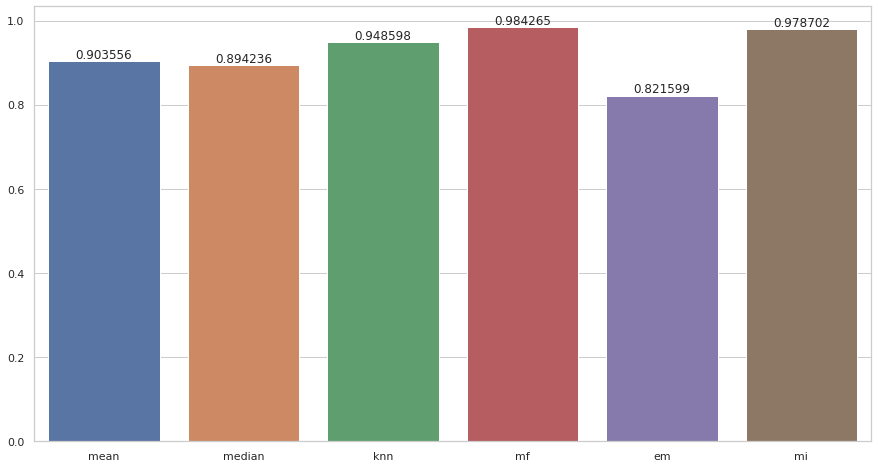

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

r2Scores = [meanR2, medianR2, knnR2, mfR2, emR2, miR2]
algos = ['mean', 'median', 'knn', 'mf', 'em', 'mi']

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15,8))
ax = sns.barplot(x=algos, y=r2Scores)
ax.bar_label(ax.containers[0])

### Use MissForest to impute missing values

In [36]:
tempDf1 = dataDf.drop(['micro_specimen_id', 'person_id'], axis = 1)
mfImputer = MissForest()
mfImputedData = mfImputer.fit(tempDf1).transform(tempDf1)
mfImputedDf = pd.DataFrame(mfImputedData, columns=tempDf1.columns, index=tempDf1.index)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [37]:
mfImputedDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [38]:
tempDf2 = mfImputedDf.join(dataDf[['micro_specimen_id', 'person_id']])
tempDf2

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic,micro_specimen_id,person_id
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778,2940,-470494077
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778,3236,-762840899
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081,3720,-1481508426
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961,5214,2090709572
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054,10611,-961491032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126,9986222,-1199717531
7098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577,9989349,-1246337626
7099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778,9989996,-1704051650
7100,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990,9996881,768076701


In [39]:
import os

outPath = os.getcwd() + '/data/data_matrix_qc_1.csv'
tempDf2.to_csv(outPath)

## Anomaly detection

### Read anomaly file from R

In [49]:
import os

anomalyPath = os.getcwd() + '/data/data_matrix_anomalies.csv'
anomaliesDf = pd.read_csv(anomalyPath)

In [50]:
anomaliesDf.head()

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory.Clinic...Center,...,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores
0,2940,-470494077,0,0,0,1,1,1,1,0,...,0.048541,-0.857543,-0.077536,0.018778,379.972608,0.977069,1.018266,NaN,1.000000,9.475134
1,3236,-762840899,0,1,1,1,1,1,1,0,...,0.621905,-1.037712,0.988716,0.018778,313.696886,1.008614,0.917349,NaN,1.000000,9.341630
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,1.004149,-0.377094,-0.290787,0.022081,389.360298,1.440800,1.443654,1.00000,1.000000,11.626273
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-1.098189,-0.677375,-0.504037,-1.107961,212.152455,1.007702,0.963503,0.04563,0.975748,8.984906
4,10611,-961491032,0,0,0,0,0,0,0,0,...,-0.333703,0.043300,-0.859455,0.034054,422.976298,1.175172,0.955352,1.00000,1.000000,10.525898


### Distribution of ensemble scores

<AxesSubplot:>

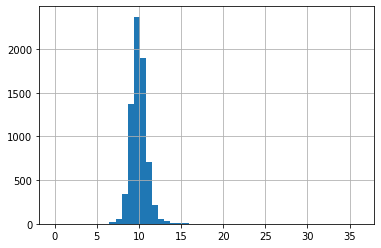

In [52]:
anomaliesDf['ensemble_scores'].hist(bins=50)

### Flag anomalies from ensemble scores

In [53]:
q1 = anomaliesDf['ensemble_scores'].quantile(0.25)
q3 = anomaliesDf['ensemble_scores'].quantile(0.75)
iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
anomaliesDf['anomaly'] = ((anomaliesDf['ensemble_scores'] > fence_low) & (anomaliesDf['ensemble_scores'] < fence_high))

In [54]:
anomaliesDf.head()

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory.Clinic...Center,...,hemoglobin_last,creatinine_last,time_to_antibiotic,y_knn_agg,y_lof,y_inflo,y_kdeos,y_ldf,ensemble_scores,anomaly
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.857543,-0.077536,0.018778,379.972608,0.977069,1.018266,NaN,1.000000,9.475134,True
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-1.037712,0.988716,0.018778,313.696886,1.008614,0.917349,NaN,1.000000,9.341630,True
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.377094,-0.290787,0.022081,389.360298,1.440800,1.443654,1.00000,1.000000,11.626273,True
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.677375,-0.504037,-1.107961,212.152455,1.007702,0.963503,0.04563,0.975748,8.984906,True
4,10611,-961491032,0,0,0,0,0,0,0,0,...,0.043300,-0.859455,0.034054,422.976298,1.175172,0.955352,1.00000,1.000000,10.525898,True


### Remove anomalies

In [55]:
outputDf = anomaliesDf[anomaliesDf.anomaly]

In [56]:
outputDf.shape

(6929, 175)

### Create output table and dump QC data

In [61]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_qc_2 cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_qc_2 (
"micro_specimen_id" bigint,
"person_id" bigint,
"seven_day_mortality" integer,
"fourteen_day_mortality" integer,
"twentyone_day_mortality" integer,
"twentyeight_day_mortality" integer,
"sixty_day_mortality" integer,
"ninety_day_mortality" integer,
"onetwenty_day_mortality" integer,
"Ambulatory Clinic / Center" integer,
"Ambulatory Surgical Center" integer,
"Emergency Room - Hospital" integer,
"Emergency Room and Inpatient Visit" integer,
"Inpatient Visit" integer,
"Observation Room" integer,
"AMBULATORY OBSERVATION" integer,
"DIRECT EMER." integer,
"ELECTIVE" integer,
"EU OBSERVATION" integer,
"EW EMER." integer,
"OBSERVATION ADMIT" integer,
"SURGICAL SAME DAY ADMISSION" integer,
"URGENT" integer,
"AMBULATORY SURGERY TRANSFER" integer,
"CLINIC REFERRAL" integer,
"EMERGENCY ROOM" integer,
"INFORMATION NOT AVAILABLE" integer,
"INTERNAL TRANSFER TO OR FROM PSYCH" integer,
"PACU" integer,
"PHYSICIAN REFERRAL" integer,
"PROCEDURE SITE" integer,
"TRANSFER FROM HOSPITAL" integer,
"TRANSFER FROM SKILLED NURSING FACILITY" integer,
"WALK-IN/SELF REFERRAL" integer,
"visit_duration_hrs" numeric,
"temp_max" numeric,
"heartrate_max" numeric,
"breath_rate_vent_max" numeric,
"breath_rate_spon_max" numeric,
"resp_rate_max" numeric,
"oxygen_max" numeric,
"sysbp_max" numeric,
"diabp_max" numeric,
"meanbp_max" numeric,
"sysbp_ni_max" numeric,
"diabp_ni_max" numeric,
"meanbp_ni_max" numeric,
"gcs_motor_max" numeric,
"gcs_verbal_max" numeric,
"gcs_eye_max" numeric,
"temp_min" numeric,
"heartrate_min" numeric,
"breath_rate_vent_min" numeric,
"breath_rate_spon_min" numeric,
"resp_rate_min" numeric,
"oxygen_min" numeric,
"sysbp_min" numeric,
"diabp_min" numeric,
"meanbp_min" numeric,
"sysbp_ni_min" numeric,
"diabp_ni_min" numeric,
"meanbp_ni_min" numeric,
"gcs_motor_min" numeric,
"gcs_verbal_min" numeric,
"gcs_eye_min" numeric,
"temp_avg" numeric,
"heartrate_avg" numeric,
"breath_rate_vent_avg" numeric,
"breath_rate_spon_avg" numeric,
"resp_rate_avg" numeric,
"oxygen_avg" numeric,
"sysbp_avg" numeric,
"diabp_avg" numeric,
"meanbp_avg" numeric,
"sysbp_ni_avg" numeric,
"diabp_ni_avg" numeric,
"meanbp_ni_avg" numeric,
"gcs_motor_avg" numeric,
"gcs_verbal_avg" numeric,
"gcs_eye_avg" numeric,
"temp_sd" numeric,
"heartrate_sd" numeric,
"breath_rate_vent_sd" numeric,
"breath_rate_spon_sd" numeric,
"resp_rate_sd" numeric,
"oxygen_sd" numeric,
"sysbp_sd" numeric,
"diabp_sd" numeric,
"meanbp_sd" numeric,
"sysbp_ni_sd" numeric,
"diabp_ni_sd" numeric,
"meanbp_ni_sd" numeric,
"gcs_motor_sd" numeric,
"gcs_verbal_sd" numeric,
"gcs_eye_sd" numeric,
"temp_first" numeric,
"heartrate_first" numeric,
"breath_rate_vent_first" numeric,
"breath_rate_spon_first" numeric,
"resp_rate_first" numeric,
"oxygen_first" numeric,
"sysbp_first" numeric,
"diabp_first" numeric,
"meanbp_first" numeric,
"sysbp_ni_first" numeric,
"diabp_ni_first" numeric,
"meanbp_ni_first" numeric,
"gcs_motor_first" numeric,
"gcs_verbal_first" numeric,
"gcs_eye_first" numeric,
"temp_last" numeric,
"heartrate_last" numeric,
"breath_rate_vent_last" numeric,
"breath_rate_spon_last" numeric,
"resp_rate_last" numeric,
"oxygen_last" numeric,
"sysbp_last" numeric,
"diabp_last" numeric,
"meanbp_last" numeric,
"sysbp_ni_last" numeric,
"diabp_ni_last" numeric,
"meanbp_ni_last" numeric,
"gcs_motor_last" numeric,
"gcs_verbal_last" numeric,
"gcs_eye_last" numeric,
"potassium_max" numeric,
"chloride_max" numeric,
"glucose_max" numeric,
"sodium_max" numeric,
"bicarbonate_max" numeric,
"hemoglobin_max" numeric,
"creatinine_max" numeric,
"potassium_min" numeric,
"chloride_min" numeric,
"glucose_min" numeric,
"sodium_min" numeric,
"bicarbonate_min" numeric,
"hemoglobin_min" numeric,
"creatinine_min" numeric,
"potassium_avg" numeric,
"chloride_avg" numeric,
"glucose_avg" numeric,
"sodium_avg" numeric,
"bicarbonate_avg" numeric,
"hemoglobin_avg" numeric,
"creatinine_avg" numeric,
"potassium_sd" numeric,
"chloride_sd" numeric,
"glucose_sd" numeric,
"sodium_sd" numeric,
"bicarbonate_sd" numeric,
"hemoglobin_sd" numeric,
"creatinine_sd" numeric,
"potassium_first" numeric,
"chloride_first" numeric,
"glucose_first" numeric,
"sodium_first" numeric,
"bicarbonate_first" numeric,
"hemoglobin_first" numeric,
"creatinine_first" numeric,
"potassium_last" numeric,
"chloride_last" numeric,
"glucose_last" numeric,
"sodium_last" numeric,
"bicarbonate_last" numeric,
"hemoglobin_last" numeric,
"creatinine_last" numeric,
"time_to_antibiotic" numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [74]:
db_columns = [
"micro_specimen_id",
"person_id",
"seven_day_mortality",
"fourteen_day_mortality",
"twentyone_day_mortality",
"twentyeight_day_mortality",
"sixty_day_mortality",
"ninety_day_mortality",
"onetwenty_day_mortality",
"Ambulatory Clinic / Center",
"Ambulatory Surgical Center",
"Emergency Room - Hospital",
"Emergency Room and Inpatient Visit",
"Inpatient Visit",
"Observation Room",
"AMBULATORY OBSERVATION",
"DIRECT EMER.",
"ELECTIVE",
"EU OBSERVATION",
"EW EMER.",
"OBSERVATION ADMIT",
"SURGICAL SAME DAY ADMISSION",
"URGENT",
"AMBULATORY SURGERY TRANSFER",
"CLINIC REFERRAL",
"EMERGENCY ROOM",
"INFORMATION NOT AVAILABLE",
"INTERNAL TRANSFER TO OR FROM PSYCH",
"PACU",
"PHYSICIAN REFERRAL",
"PROCEDURE SITE",
"TRANSFER FROM HOSPITAL",
"TRANSFER FROM SKILLED NURSING FACILITY",
"WALK-IN/SELF REFERRAL",
"visit_duration_hrs",
"temp_max",
"heartrate_max",
"breath_rate_vent_max",
"breath_rate_spon_max",
"resp_rate_max",
"oxygen_max",
"sysbp_max",
"diabp_max",
"meanbp_max",
"sysbp_ni_max",
"diabp_ni_max",
"meanbp_ni_max",
"gcs_motor_max",
"gcs_verbal_max",
"gcs_eye_max",
"temp_min",
"heartrate_min",
"breath_rate_vent_min",
"breath_rate_spon_min",
"resp_rate_min",
"oxygen_min",
"sysbp_min",
"diabp_min",
"meanbp_min",
"sysbp_ni_min",
"diabp_ni_min",
"meanbp_ni_min",
"gcs_motor_min",
"gcs_verbal_min",
"gcs_eye_min",
"temp_avg",
"heartrate_avg",
"breath_rate_vent_avg",
"breath_rate_spon_avg",
"resp_rate_avg",
"oxygen_avg",
"sysbp_avg",
"diabp_avg",
"meanbp_avg",
"sysbp_ni_avg",
"diabp_ni_avg",
"meanbp_ni_avg",
"gcs_motor_avg",
"gcs_verbal_avg",
"gcs_eye_avg",
"temp_sd",
"heartrate_sd",
"breath_rate_vent_sd",
"breath_rate_spon_sd",
"resp_rate_sd",
"oxygen_sd",
"sysbp_sd",
"diabp_sd",
"meanbp_sd",
"sysbp_ni_sd",
"diabp_ni_sd",
"meanbp_ni_sd",
"gcs_motor_sd",
"gcs_verbal_sd",
"gcs_eye_sd",
"temp_first",
"heartrate_first",
"breath_rate_vent_first",
"breath_rate_spon_first",
"resp_rate_first",
"oxygen_first",
"sysbp_first",
"diabp_first",
"meanbp_first",
"sysbp_ni_first",
"diabp_ni_first",
"meanbp_ni_first",
"gcs_motor_first",
"gcs_verbal_first",
"gcs_eye_first",
"temp_last",
"heartrate_last",
"breath_rate_vent_last",
"breath_rate_spon_last",
"resp_rate_last",
"oxygen_last",
"sysbp_last",
"diabp_last",
"meanbp_last",
"sysbp_ni_last",
"diabp_ni_last",
"meanbp_ni_last",
"gcs_motor_last",
"gcs_verbal_last",
"gcs_eye_last",
"potassium_max",
"chloride_max",
"glucose_max",
"sodium_max",
"bicarbonate_max",
"hemoglobin_max",
"creatinine_max",
"potassium_min",
"chloride_min",
"glucose_min",
"sodium_min",
"bicarbonate_min",
"hemoglobin_min",
"creatinine_min",
"potassium_avg",
"chloride_avg",
"glucose_avg",
"sodium_avg",
"bicarbonate_avg",
"hemoglobin_avg",
"creatinine_avg",
"potassium_sd",
"chloride_sd",
"glucose_sd",
"sodium_sd",
"bicarbonate_sd",
"hemoglobin_sd",
"creatinine_sd",
"potassium_first",
"chloride_first",
"glucose_first",
"sodium_first",
"bicarbonate_first",
"hemoglobin_first",
"creatinine_first",
"potassium_last",
"chloride_last",
"glucose_last",
"sodium_last",
"bicarbonate_last",
"hemoglobin_last",
"creatinine_last",
"time_to_antibiotic"
]

In [75]:
df_columns = [
 'micro_specimen_id',
 'person_id',
 'seven_day_mortality',
 'fourteen_day_mortality',
 'twentyone_day_mortality',
 'twentyeight_day_mortality',
 'sixty_day_mortality',
 'ninety_day_mortality',
 'onetwenty_day_mortality',
 'Ambulatory.Clinic...Center',
 'Ambulatory.Surgical.Center',
 'Emergency.Room...Hospital',
 'Emergency.Room.and.Inpatient.Visit',
 'Inpatient.Visit',
 'Observation.Room',
 'AMBULATORY.OBSERVATION',
 'DIRECT.EMER.',
 'ELECTIVE',
 'EU.OBSERVATION',
 'EW.EMER.',
 'OBSERVATION.ADMIT',
 'SURGICAL.SAME.DAY.ADMISSION',
 'URGENT',
 'AMBULATORY.SURGERY.TRANSFER',
 'CLINIC.REFERRAL',
 'EMERGENCY.ROOM',
 'INFORMATION.NOT.AVAILABLE',
 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH',
 'PACU',
 'PHYSICIAN.REFERRAL',
 'PROCEDURE.SITE',
 'TRANSFER.FROM.HOSPITAL',
 'TRANSFER.FROM.SKILLED.NURSING.FACILITY',
 'WALK.IN.SELF.REFERRAL',
 'visit_duration_hrs',
 'temp_max',
 'heartrate_max',
 'breath_rate_vent_max',
 'breath_rate_spon_max',
 'resp_rate_max',
 'oxygen_max',
 'sysbp_max',
 'diabp_max',
 'meanbp_max',
 'sysbp_ni_max',
 'diabp_ni_max',
 'meanbp_ni_max',
 'gcs_motor_max',
 'gcs_verbal_max',
 'gcs_eye_max',
 'temp_min',
 'heartrate_min',
 'breath_rate_vent_min',
 'breath_rate_spon_min',
 'resp_rate_min',
 'oxygen_min',
 'sysbp_min',
 'diabp_min',
 'meanbp_min',
 'sysbp_ni_min',
 'diabp_ni_min',
 'meanbp_ni_min',
 'gcs_motor_min',
 'gcs_verbal_min',
 'gcs_eye_min',
 'temp_avg',
 'heartrate_avg',
 'breath_rate_vent_avg',
 'breath_rate_spon_avg',
 'resp_rate_avg',
 'oxygen_avg',
 'sysbp_avg',
 'diabp_avg',
 'meanbp_avg',
 'sysbp_ni_avg',
 'diabp_ni_avg',
 'meanbp_ni_avg',
 'gcs_motor_avg',
 'gcs_verbal_avg',
 'gcs_eye_avg',
 'temp_sd',
 'heartrate_sd',
 'breath_rate_vent_sd',
 'breath_rate_spon_sd',
 'resp_rate_sd',
 'oxygen_sd',
 'sysbp_sd',
 'diabp_sd',
 'meanbp_sd',
 'sysbp_ni_sd',
 'diabp_ni_sd',
 'meanbp_ni_sd',
 'gcs_motor_sd',
 'gcs_verbal_sd',
 'gcs_eye_sd',
 'temp_first',
 'heartrate_first',
 'breath_rate_vent_first',
 'breath_rate_spon_first',
 'resp_rate_first',
 'oxygen_first',
 'sysbp_first',
 'diabp_first',
 'meanbp_first',
 'sysbp_ni_first',
 'diabp_ni_first',
 'meanbp_ni_first',
 'gcs_motor_first',
 'gcs_verbal_first',
 'gcs_eye_first',
 'temp_last',
 'heartrate_last',
 'breath_rate_vent_last',
 'breath_rate_spon_last',
 'resp_rate_last',
 'oxygen_last',
 'sysbp_last',
 'diabp_last',
 'meanbp_last',
 'sysbp_ni_last',
 'diabp_ni_last',
 'meanbp_ni_last',
 'gcs_motor_last',
 'gcs_verbal_last',
 'gcs_eye_last',
 'potassium_max',
 'chloride_max',
 'glucose_max',
 'sodium_max',
 'bicarbonate_max',
 'hemoglobin_max',
 'creatinine_max',
 'potassium_min',
 'chloride_min',
 'glucose_min',
 'sodium_min',
 'bicarbonate_min',
 'hemoglobin_min',
 'creatinine_min',
 'potassium_avg',
 'chloride_avg',
 'glucose_avg',
 'sodium_avg',
 'bicarbonate_avg',
 'hemoglobin_avg',
 'creatinine_avg',
 'potassium_sd',
 'chloride_sd',
 'glucose_sd',
 'sodium_sd',
 'bicarbonate_sd',
 'hemoglobin_sd',
 'creatinine_sd',
 'potassium_first',
 'chloride_first',
 'glucose_first',
 'sodium_first',
 'bicarbonate_first',
 'hemoglobin_first',
 'creatinine_first',
 'potassium_last',
 'chloride_last',
 'glucose_last',
 'sodium_last',
 'bicarbonate_last',
 'hemoglobin_last',
 'creatinine_last',
 'time_to_antibiotic',
]


In [81]:
import psycopg2.extras

if len(outputDf) > 0:

    table = 'sepsis_micro.data_matrix_qc_2'

    # df_columns = ['micro_specimen_id', 'person_id', 'discharge_mortality', 'one_day_mortality', 'two_day_mortality', 'thirty_day_mortality', 'sixty_day_mortality', 'ninety_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last', 'time_to_antibiotic']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(db_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, outputDf[df_columns].values)
    con.commit()
    cur.close()

## Read QC_1 File (only missing data imputation, no anomaly removal)

In [44]:
import os

dataPath = os.getcwd() + '/data/data_matrix_qc_1.csv'
dataDf = pd.read_csv(dataPath, index_col=0)
dataDf

,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,Ambulatory Surgical Center,Emergency Room - Hospital,...,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic,micro_specimen_id,person_id
0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778,2940,-470494077
1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778,3236,-762840899
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081,3720,-1481508426
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961,5214,2090709572
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054,10611,-961491032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126,9986222,-1199717531
7098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577,9989349,-1246337626
7099,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778,9989996,-1704051650
7100,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990,9996881,768076701


In [46]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_qc_1 cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_qc_1 (
"micro_specimen_id" bigint,
"person_id" bigint,
"seven_day_mortality" integer,
"fourteen_day_mortality" integer,
"twentyone_day_mortality" integer,
"twentyeight_day_mortality" integer,
"sixty_day_mortality" integer,
"ninety_day_mortality" integer,
"onetwenty_day_mortality" integer,
"Ambulatory Clinic / Center" integer,
"Ambulatory Surgical Center" integer,
"Emergency Room - Hospital" integer,
"Emergency Room and Inpatient Visit" integer,
"Inpatient Visit" integer,
"Observation Room" integer,
"AMBULATORY OBSERVATION" integer,
"DIRECT EMER." integer,
"ELECTIVE" integer,
"EU OBSERVATION" integer,
"EW EMER." integer,
"OBSERVATION ADMIT" integer,
"SURGICAL SAME DAY ADMISSION" integer,
"URGENT" integer,
"AMBULATORY SURGERY TRANSFER" integer,
"CLINIC REFERRAL" integer,
"EMERGENCY ROOM" integer,
"INFORMATION NOT AVAILABLE" integer,
"INTERNAL TRANSFER TO OR FROM PSYCH" integer,
"PACU" integer,
"PHYSICIAN REFERRAL" integer,
"PROCEDURE SITE" integer,
"TRANSFER FROM HOSPITAL" integer,
"TRANSFER FROM SKILLED NURSING FACILITY" integer,
"WALK-IN/SELF REFERRAL" integer,
"visit_duration_hrs" numeric,
"temp_max" numeric,
"heartrate_max" numeric,
"breath_rate_vent_max" numeric,
"breath_rate_spon_max" numeric,
"resp_rate_max" numeric,
"oxygen_max" numeric,
"sysbp_max" numeric,
"diabp_max" numeric,
"meanbp_max" numeric,
"sysbp_ni_max" numeric,
"diabp_ni_max" numeric,
"meanbp_ni_max" numeric,
"gcs_motor_max" numeric,
"gcs_verbal_max" numeric,
"gcs_eye_max" numeric,
"temp_min" numeric,
"heartrate_min" numeric,
"breath_rate_vent_min" numeric,
"breath_rate_spon_min" numeric,
"resp_rate_min" numeric,
"oxygen_min" numeric,
"sysbp_min" numeric,
"diabp_min" numeric,
"meanbp_min" numeric,
"sysbp_ni_min" numeric,
"diabp_ni_min" numeric,
"meanbp_ni_min" numeric,
"gcs_motor_min" numeric,
"gcs_verbal_min" numeric,
"gcs_eye_min" numeric,
"temp_avg" numeric,
"heartrate_avg" numeric,
"breath_rate_vent_avg" numeric,
"breath_rate_spon_avg" numeric,
"resp_rate_avg" numeric,
"oxygen_avg" numeric,
"sysbp_avg" numeric,
"diabp_avg" numeric,
"meanbp_avg" numeric,
"sysbp_ni_avg" numeric,
"diabp_ni_avg" numeric,
"meanbp_ni_avg" numeric,
"gcs_motor_avg" numeric,
"gcs_verbal_avg" numeric,
"gcs_eye_avg" numeric,
"temp_sd" numeric,
"heartrate_sd" numeric,
"breath_rate_vent_sd" numeric,
"breath_rate_spon_sd" numeric,
"resp_rate_sd" numeric,
"oxygen_sd" numeric,
"sysbp_sd" numeric,
"diabp_sd" numeric,
"meanbp_sd" numeric,
"sysbp_ni_sd" numeric,
"diabp_ni_sd" numeric,
"meanbp_ni_sd" numeric,
"gcs_motor_sd" numeric,
"gcs_verbal_sd" numeric,
"gcs_eye_sd" numeric,
"temp_first" numeric,
"heartrate_first" numeric,
"breath_rate_vent_first" numeric,
"breath_rate_spon_first" numeric,
"resp_rate_first" numeric,
"oxygen_first" numeric,
"sysbp_first" numeric,
"diabp_first" numeric,
"meanbp_first" numeric,
"sysbp_ni_first" numeric,
"diabp_ni_first" numeric,
"meanbp_ni_first" numeric,
"gcs_motor_first" numeric,
"gcs_verbal_first" numeric,
"gcs_eye_first" numeric,
"temp_last" numeric,
"heartrate_last" numeric,
"breath_rate_vent_last" numeric,
"breath_rate_spon_last" numeric,
"resp_rate_last" numeric,
"oxygen_last" numeric,
"sysbp_last" numeric,
"diabp_last" numeric,
"meanbp_last" numeric,
"sysbp_ni_last" numeric,
"diabp_ni_last" numeric,
"meanbp_ni_last" numeric,
"gcs_motor_last" numeric,
"gcs_verbal_last" numeric,
"gcs_eye_last" numeric,
"potassium_max" numeric,
"chloride_max" numeric,
"glucose_max" numeric,
"sodium_max" numeric,
"bicarbonate_max" numeric,
"hemoglobin_max" numeric,
"creatinine_max" numeric,
"potassium_min" numeric,
"chloride_min" numeric,
"glucose_min" numeric,
"sodium_min" numeric,
"bicarbonate_min" numeric,
"hemoglobin_min" numeric,
"creatinine_min" numeric,
"potassium_avg" numeric,
"chloride_avg" numeric,
"glucose_avg" numeric,
"sodium_avg" numeric,
"bicarbonate_avg" numeric,
"hemoglobin_avg" numeric,
"creatinine_avg" numeric,
"potassium_sd" numeric,
"chloride_sd" numeric,
"glucose_sd" numeric,
"sodium_sd" numeric,
"bicarbonate_sd" numeric,
"hemoglobin_sd" numeric,
"creatinine_sd" numeric,
"potassium_first" numeric,
"chloride_first" numeric,
"glucose_first" numeric,
"sodium_first" numeric,
"bicarbonate_first" numeric,
"hemoglobin_first" numeric,
"creatinine_first" numeric,
"potassium_last" numeric,
"chloride_last" numeric,
"glucose_last" numeric,
"sodium_last" numeric,
"bicarbonate_last" numeric,
"hemoglobin_last" numeric,
"creatinine_last" numeric,
"time_to_antibiotic" numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [47]:
df_columns = [
  'micro_specimen_id',
  'person_id',
  'seven_day_mortality',
  'fourteen_day_mortality',
  'twentyone_day_mortality',
  'twentyeight_day_mortality',
  'sixty_day_mortality',
  'ninety_day_mortality',
  'onetwenty_day_mortality',
  'Ambulatory Clinic / Center',
  'Ambulatory Surgical Center',
  'Emergency Room - Hospital',
  'Emergency Room and Inpatient Visit',
  'Inpatient Visit',
  'Observation Room',
  'AMBULATORY OBSERVATION',
  'DIRECT EMER.',
  'ELECTIVE',
  'EU OBSERVATION',
  'EW EMER.',
  'OBSERVATION ADMIT',
  'SURGICAL SAME DAY ADMISSION',
  'URGENT',
  'AMBULATORY SURGERY TRANSFER',
  'CLINIC REFERRAL',
  'EMERGENCY ROOM',
  'INFORMATION NOT AVAILABLE',
  'INTERNAL TRANSFER TO OR FROM PSYCH',
  'PACU',
  'PHYSICIAN REFERRAL',
  'PROCEDURE SITE',
  'TRANSFER FROM HOSPITAL',
  'TRANSFER FROM SKILLED NURSING FACILITY',
  'WALK-IN/SELF REFERRAL',
  'visit_duration_hrs',
  'temp_max',
  'heartrate_max',
  'breath_rate_vent_max',
  'breath_rate_spon_max',
  'resp_rate_max',
  'oxygen_max',
  'sysbp_max',
  'diabp_max',
  'meanbp_max',
  'sysbp_ni_max',
  'diabp_ni_max',
  'meanbp_ni_max',
  'gcs_motor_max',
  'gcs_verbal_max',
  'gcs_eye_max',
  'temp_min',
  'heartrate_min',
  'breath_rate_vent_min',
  'breath_rate_spon_min',
  'resp_rate_min',
  'oxygen_min',
  'sysbp_min',
  'diabp_min',
  'meanbp_min',
  'sysbp_ni_min',
  'diabp_ni_min',
  'meanbp_ni_min',
  'gcs_motor_min',
  'gcs_verbal_min',
  'gcs_eye_min',
  'temp_avg',
  'heartrate_avg',
  'breath_rate_vent_avg',
  'breath_rate_spon_avg',
  'resp_rate_avg',
  'oxygen_avg',
  'sysbp_avg',
  'diabp_avg',
  'meanbp_avg',
  'sysbp_ni_avg',
  'diabp_ni_avg',
  'meanbp_ni_avg',
  'gcs_motor_avg',
  'gcs_verbal_avg',
  'gcs_eye_avg',
  'temp_sd',
  'heartrate_sd',
  'breath_rate_vent_sd',
  'breath_rate_spon_sd',
  'resp_rate_sd',
  'oxygen_sd',
  'sysbp_sd',
  'diabp_sd',
  'meanbp_sd',
  'sysbp_ni_sd',
  'diabp_ni_sd',
  'meanbp_ni_sd',
  'gcs_motor_sd',
  'gcs_verbal_sd',
  'gcs_eye_sd',
  'temp_first',
  'heartrate_first',
  'breath_rate_vent_first',
  'breath_rate_spon_first',
  'resp_rate_first',
  'oxygen_first',
  'sysbp_first',
  'diabp_first',
  'meanbp_first',
  'sysbp_ni_first',
  'diabp_ni_first',
  'meanbp_ni_first',
  'gcs_motor_first',
  'gcs_verbal_first',
  'gcs_eye_first',
  'temp_last',
  'heartrate_last',
  'breath_rate_vent_last',
  'breath_rate_spon_last',
  'resp_rate_last',
  'oxygen_last',
  'sysbp_last',
  'diabp_last',
  'meanbp_last',
  'sysbp_ni_last',
  'diabp_ni_last',
  'meanbp_ni_last',
  'gcs_motor_last',
  'gcs_verbal_last',
  'gcs_eye_last',
  'potassium_max',
  'chloride_max',
  'glucose_max',
  'sodium_max',
  'bicarbonate_max',
  'hemoglobin_max',
  'creatinine_max',
  'potassium_min',
  'chloride_min',
  'glucose_min',
  'sodium_min',
  'bicarbonate_min',
  'hemoglobin_min',
  'creatinine_min',
  'potassium_avg',
  'chloride_avg',
  'glucose_avg',
  'sodium_avg',
  'bicarbonate_avg',
  'hemoglobin_avg',
  'creatinine_avg',
  'potassium_sd',
  'chloride_sd',
  'glucose_sd',
  'sodium_sd',
  'bicarbonate_sd',
  'hemoglobin_sd',
  'creatinine_sd',
  'potassium_first',
  'chloride_first',
  'glucose_first',
  'sodium_first',
  'bicarbonate_first',
  'hemoglobin_first',
  'creatinine_first',
  'potassium_last',
  'chloride_last',
  'glucose_last',
  'sodium_last',
  'bicarbonate_last',
  'hemoglobin_last',
  'creatinine_last',
  'time_to_antibiotic'
]

In [48]:
import psycopg2.extras

if len(dataDf) > 0:

    table = 'sepsis_micro.data_matrix_qc_1'

    # df_columns = ['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality',	'ninety_day_mortality',	'onetwenty_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(df_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, dataDf[df_columns].values)
    con.commit()
    cur.close()

## Read Without QC File

In [2]:
import os

originalPath = os.getcwd() + '/data/data_matrix_no_qc.csv'
originalDf = pd.read_csv(originalPath, index_col=0)
originalDf

,micro_specimen_id,person_id,seven_day_mortality,fourteen_day_mortality,twentyone_day_mortality,twentyeight_day_mortality,sixty_day_mortality,ninety_day_mortality,onetwenty_day_mortality,Ambulatory Clinic / Center,...,hemoglobin_first,creatinine_first,potassium_last,chloride_last,glucose_last,sodium_last,bicarbonate_last,hemoglobin_last,creatinine_last,time_to_antibiotic
0,2940,-470494077,0,0,0,1,1,1,1,0,...,-0.586379,2.441041,-0.053360,-0.804726,0.726778,-0.800329,0.048541,-0.857543,-0.077536,0.018778
1,3236,-762840899,0,1,1,1,1,1,1,0,...,-0.942367,-0.066982,1.677597,-1.840315,0.615396,-1.745000,0.621905,-1.037712,0.988716,0.018778
2,3720,-1481508426,0,0,0,0,0,0,0,0,...,-0.535524,-0.345652,-1.438125,-1.692373,1.376502,-0.989263,1.004149,-0.377094,-0.290787,0.022081
3,5214,2090709572,0,0,0,0,0,0,0,0,...,-0.789801,-0.554654,0.292832,-0.508844,-0.164272,-1.745000,-1.098189,-0.677375,-0.504037,-1.107961
4,10611,-961491032,0,0,0,0,0,0,0,0,...,1.091850,-0.763656,-0.399551,1.414391,0.763905,0.333277,-0.333703,0.043300,-0.859455,0.034054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7097,9986222,-1199717531,0,0,0,0,0,0,0,0,...,1.447838,-0.554654,0.465927,-0.065021,-0.498416,0.900080,2.533121,-0.377094,-0.575121,0.017126
7098,9989349,-1246337626,0,0,0,0,0,0,0,0,...,1.244416,1.953370,-0.399551,-1.248550,1.357938,-1.745000,-0.715946,0.463693,1.841718,0.031577
7099,9989996,-1704051650,1,1,1,1,1,1,1,0,...,-1.247500,-0.693988,0.119736,0.082921,-0.758306,-1.178197,-0.907067,-1.337993,-0.646204,0.018778
7100,9996881,768076701,0,0,1,1,1,1,1,0,...,-0.586379,-0.833323,-0.572647,-0.656785,-0.609797,0.144343,2.150878,-0.437150,-0.788371,0.031990


In [6]:
dropTableQuery = """drop table if exists sepsis_micro.data_matrix_no_qc cascade;"""
createTableQuery = """create table sepsis_micro.data_matrix_no_qc (
"micro_specimen_id" bigint,
"person_id" bigint,
"seven_day_mortality" integer,
"fourteen_day_mortality" integer,
"twentyone_day_mortality" integer,
"twentyeight_day_mortality" integer,
"sixty_day_mortality" integer,
"ninety_day_mortality" integer,
"onetwenty_day_mortality" integer,
"Ambulatory Clinic / Center" integer,
"Ambulatory Surgical Center" integer,
"Emergency Room - Hospital" integer,
"Emergency Room and Inpatient Visit" integer,
"Inpatient Visit" integer,
"Observation Room" integer,
"AMBULATORY OBSERVATION" integer,
"DIRECT EMER." integer,
"ELECTIVE" integer,
"EU OBSERVATION" integer,
"EW EMER." integer,
"OBSERVATION ADMIT" integer,
"SURGICAL SAME DAY ADMISSION" integer,
"URGENT" integer,
"AMBULATORY SURGERY TRANSFER" integer,
"CLINIC REFERRAL" integer,
"EMERGENCY ROOM" integer,
"INFORMATION NOT AVAILABLE" integer,
"INTERNAL TRANSFER TO OR FROM PSYCH" integer,
"PACU" integer,
"PHYSICIAN REFERRAL" integer,
"PROCEDURE SITE" integer,
"TRANSFER FROM HOSPITAL" integer,
"TRANSFER FROM SKILLED NURSING FACILITY" integer,
"WALK-IN/SELF REFERRAL" integer,
"visit_duration_hrs" numeric,
"temp_max" numeric,
"heartrate_max" numeric,
"breath_rate_vent_max" numeric,
"breath_rate_spon_max" numeric,
"resp_rate_max" numeric,
"oxygen_max" numeric,
"sysbp_max" numeric,
"diabp_max" numeric,
"meanbp_max" numeric,
"sysbp_ni_max" numeric,
"diabp_ni_max" numeric,
"meanbp_ni_max" numeric,
"gcs_motor_max" numeric,
"gcs_verbal_max" numeric,
"gcs_eye_max" numeric,
"temp_min" numeric,
"heartrate_min" numeric,
"breath_rate_vent_min" numeric,
"breath_rate_spon_min" numeric,
"resp_rate_min" numeric,
"oxygen_min" numeric,
"sysbp_min" numeric,
"diabp_min" numeric,
"meanbp_min" numeric,
"sysbp_ni_min" numeric,
"diabp_ni_min" numeric,
"meanbp_ni_min" numeric,
"gcs_motor_min" numeric,
"gcs_verbal_min" numeric,
"gcs_eye_min" numeric,
"temp_avg" numeric,
"heartrate_avg" numeric,
"breath_rate_vent_avg" numeric,
"breath_rate_spon_avg" numeric,
"resp_rate_avg" numeric,
"oxygen_avg" numeric,
"sysbp_avg" numeric,
"diabp_avg" numeric,
"meanbp_avg" numeric,
"sysbp_ni_avg" numeric,
"diabp_ni_avg" numeric,
"meanbp_ni_avg" numeric,
"gcs_motor_avg" numeric,
"gcs_verbal_avg" numeric,
"gcs_eye_avg" numeric,
"temp_sd" numeric,
"heartrate_sd" numeric,
"breath_rate_vent_sd" numeric,
"breath_rate_spon_sd" numeric,
"resp_rate_sd" numeric,
"oxygen_sd" numeric,
"sysbp_sd" numeric,
"diabp_sd" numeric,
"meanbp_sd" numeric,
"sysbp_ni_sd" numeric,
"diabp_ni_sd" numeric,
"meanbp_ni_sd" numeric,
"gcs_motor_sd" numeric,
"gcs_verbal_sd" numeric,
"gcs_eye_sd" numeric,
"temp_first" numeric,
"heartrate_first" numeric,
"breath_rate_vent_first" numeric,
"breath_rate_spon_first" numeric,
"resp_rate_first" numeric,
"oxygen_first" numeric,
"sysbp_first" numeric,
"diabp_first" numeric,
"meanbp_first" numeric,
"sysbp_ni_first" numeric,
"diabp_ni_first" numeric,
"meanbp_ni_first" numeric,
"gcs_motor_first" numeric,
"gcs_verbal_first" numeric,
"gcs_eye_first" numeric,
"temp_last" numeric,
"heartrate_last" numeric,
"breath_rate_vent_last" numeric,
"breath_rate_spon_last" numeric,
"resp_rate_last" numeric,
"oxygen_last" numeric,
"sysbp_last" numeric,
"diabp_last" numeric,
"meanbp_last" numeric,
"sysbp_ni_last" numeric,
"diabp_ni_last" numeric,
"meanbp_ni_last" numeric,
"gcs_motor_last" numeric,
"gcs_verbal_last" numeric,
"gcs_eye_last" numeric,
"potassium_max" numeric,
"chloride_max" numeric,
"glucose_max" numeric,
"sodium_max" numeric,
"bicarbonate_max" numeric,
"hemoglobin_max" numeric,
"creatinine_max" numeric,
"potassium_min" numeric,
"chloride_min" numeric,
"glucose_min" numeric,
"sodium_min" numeric,
"bicarbonate_min" numeric,
"hemoglobin_min" numeric,
"creatinine_min" numeric,
"potassium_avg" numeric,
"chloride_avg" numeric,
"glucose_avg" numeric,
"sodium_avg" numeric,
"bicarbonate_avg" numeric,
"hemoglobin_avg" numeric,
"creatinine_avg" numeric,
"potassium_sd" numeric,
"chloride_sd" numeric,
"glucose_sd" numeric,
"sodium_sd" numeric,
"bicarbonate_sd" numeric,
"hemoglobin_sd" numeric,
"creatinine_sd" numeric,
"potassium_first" numeric,
"chloride_first" numeric,
"glucose_first" numeric,
"sodium_first" numeric,
"bicarbonate_first" numeric,
"hemoglobin_first" numeric,
"creatinine_first" numeric,
"potassium_last" numeric,
"chloride_last" numeric,
"glucose_last" numeric,
"sodium_last" numeric,
"bicarbonate_last" numeric,
"hemoglobin_last" numeric,
"creatinine_last" numeric,
"time_to_antibiotic" numeric
)"""

with con:
    with con.cursor() as cursor:
        cursor.execute(dropTableQuery)
        cursor.execute(createTableQuery)

In [7]:
df_columns = [
  'micro_specimen_id',
  'person_id',
  'seven_day_mortality',
  'fourteen_day_mortality',
  'twentyone_day_mortality',
  'twentyeight_day_mortality',
  'sixty_day_mortality',
  'ninety_day_mortality',
  'onetwenty_day_mortality',
  'Ambulatory Clinic / Center',
  'Ambulatory Surgical Center',
  'Emergency Room - Hospital',
  'Emergency Room and Inpatient Visit',
  'Inpatient Visit',
  'Observation Room',
  'AMBULATORY OBSERVATION',
  'DIRECT EMER.',
  'ELECTIVE',
  'EU OBSERVATION',
  'EW EMER.',
  'OBSERVATION ADMIT',
  'SURGICAL SAME DAY ADMISSION',
  'URGENT',
  'AMBULATORY SURGERY TRANSFER',
  'CLINIC REFERRAL',
  'EMERGENCY ROOM',
  'INFORMATION NOT AVAILABLE',
  'INTERNAL TRANSFER TO OR FROM PSYCH',
  'PACU',
  'PHYSICIAN REFERRAL',
  'PROCEDURE SITE',
  'TRANSFER FROM HOSPITAL',
  'TRANSFER FROM SKILLED NURSING FACILITY',
  'WALK-IN/SELF REFERRAL',
  'visit_duration_hrs',
  'temp_max',
  'heartrate_max',
  'breath_rate_vent_max',
  'breath_rate_spon_max',
  'resp_rate_max',
  'oxygen_max',
  'sysbp_max',
  'diabp_max',
  'meanbp_max',
  'sysbp_ni_max',
  'diabp_ni_max',
  'meanbp_ni_max',
  'gcs_motor_max',
  'gcs_verbal_max',
  'gcs_eye_max',
  'temp_min',
  'heartrate_min',
  'breath_rate_vent_min',
  'breath_rate_spon_min',
  'resp_rate_min',
  'oxygen_min',
  'sysbp_min',
  'diabp_min',
  'meanbp_min',
  'sysbp_ni_min',
  'diabp_ni_min',
  'meanbp_ni_min',
  'gcs_motor_min',
  'gcs_verbal_min',
  'gcs_eye_min',
  'temp_avg',
  'heartrate_avg',
  'breath_rate_vent_avg',
  'breath_rate_spon_avg',
  'resp_rate_avg',
  'oxygen_avg',
  'sysbp_avg',
  'diabp_avg',
  'meanbp_avg',
  'sysbp_ni_avg',
  'diabp_ni_avg',
  'meanbp_ni_avg',
  'gcs_motor_avg',
  'gcs_verbal_avg',
  'gcs_eye_avg',
  'temp_sd',
  'heartrate_sd',
  'breath_rate_vent_sd',
  'breath_rate_spon_sd',
  'resp_rate_sd',
  'oxygen_sd',
  'sysbp_sd',
  'diabp_sd',
  'meanbp_sd',
  'sysbp_ni_sd',
  'diabp_ni_sd',
  'meanbp_ni_sd',
  'gcs_motor_sd',
  'gcs_verbal_sd',
  'gcs_eye_sd',
  'temp_first',
  'heartrate_first',
  'breath_rate_vent_first',
  'breath_rate_spon_first',
  'resp_rate_first',
  'oxygen_first',
  'sysbp_first',
  'diabp_first',
  'meanbp_first',
  'sysbp_ni_first',
  'diabp_ni_first',
  'meanbp_ni_first',
  'gcs_motor_first',
  'gcs_verbal_first',
  'gcs_eye_first',
  'temp_last',
  'heartrate_last',
  'breath_rate_vent_last',
  'breath_rate_spon_last',
  'resp_rate_last',
  'oxygen_last',
  'sysbp_last',
  'diabp_last',
  'meanbp_last',
  'sysbp_ni_last',
  'diabp_ni_last',
  'meanbp_ni_last',
  'gcs_motor_last',
  'gcs_verbal_last',
  'gcs_eye_last',
  'potassium_max',
  'chloride_max',
  'glucose_max',
  'sodium_max',
  'bicarbonate_max',
  'hemoglobin_max',
  'creatinine_max',
  'potassium_min',
  'chloride_min',
  'glucose_min',
  'sodium_min',
  'bicarbonate_min',
  'hemoglobin_min',
  'creatinine_min',
  'potassium_avg',
  'chloride_avg',
  'glucose_avg',
  'sodium_avg',
  'bicarbonate_avg',
  'hemoglobin_avg',
  'creatinine_avg',
  'potassium_sd',
  'chloride_sd',
  'glucose_sd',
  'sodium_sd',
  'bicarbonate_sd',
  'hemoglobin_sd',
  'creatinine_sd',
  'potassium_first',
  'chloride_first',
  'glucose_first',
  'sodium_first',
  'bicarbonate_first',
  'hemoglobin_first',
  'creatinine_first',
  'potassium_last',
  'chloride_last',
  'glucose_last',
  'sodium_last',
  'bicarbonate_last',
  'hemoglobin_last',
  'creatinine_last',
  'time_to_antibiotic'
]

In [8]:
import psycopg2.extras

if len(originalDf) > 0:

    table = 'sepsis_micro.data_matrix_no_qc'

    # df_columns = ['micro_specimen_id', 'person_id', 'seven_day_mortality', 'fourteen_day_mortality', 'twentyone_day_mortality', 'twentyeight_day_mortality', 'sixty_day_mortality',	'ninety_day_mortality',	'onetwenty_day_mortality', 'sepsis', 'Ambulatory.Clinic...Center', 'Ambulatory.Surgical.Center', 'Emergency.Room...Hospital', 'Emergency.Room.and.Inpatient.Visit', 'Inpatient.Visit', 'Observation.Room', 'AMBULATORY.OBSERVATION', 'DIRECT.EMER.', 'DIRECT.OBSERVATION', 'ELECTIVE', 'EU.OBSERVATION', 'EW.EMER.', 'OBSERVATION.ADMIT', 'SURGICAL.SAME.DAY.ADMISSION', 'URGENT', 'AMBULATORY.SURGERY.TRANSFER', 'CLINIC.REFERRAL', 'EMERGENCY.ROOM', 'INFORMATION.NOT.AVAILABLE', 'INTERNAL.TRANSFER.TO.OR.FROM.PSYCH', 'PACU', 'PHYSICIAN.REFERRAL', 'PROCEDURE.SITE', 'TRANSFER.FROM.HOSPITAL', 'TRANSFER.FROM.SKILLED.NURSING.FACILITY', 'WALK.IN.SELF.REFERRAL', 'visit_duration_hrs', 'temp_max', 'heartrate_max', 'breath_rate_vent_max', 'breath_rate_spon_max', 'resp_rate_max', 'oxygen_max', 'sysbp_max', 'diabp_max', 'meanbp_max', 'sysbp_ni_max', 'diabp_ni_max', 'meanbp_ni_max', 'gcs_motor_max', 'gcs_verbal_max', 'gcs_eye_max', 'temp_min', 'heartrate_min', 'breath_rate_vent_min', 'breath_rate_spon_min', 'resp_rate_min', 'oxygen_min', 'sysbp_min', 'diabp_min', 'meanbp_min', 'sysbp_ni_min', 'diabp_ni_min', 'meanbp_ni_min', 'gcs_motor_min', 'gcs_verbal_min', 'gcs_eye_min', 'temp_avg', 'heartrate_avg', 'breath_rate_vent_avg', 'breath_rate_spon_avg', 'resp_rate_avg', 'oxygen_avg', 'sysbp_avg', 'diabp_avg', 'meanbp_avg', 'sysbp_ni_avg', 'diabp_ni_avg', 'meanbp_ni_avg', 'gcs_motor_avg', 'gcs_verbal_avg', 'gcs_eye_avg', 'temp_sd', 'heartrate_sd', 'breath_rate_vent_sd', 'breath_rate_spon_sd', 'resp_rate_sd', 'oxygen_sd', 'sysbp_sd', 'diabp_sd', 'meanbp_sd', 'sysbp_ni_sd', 'diabp_ni_sd', 'meanbp_ni_sd', 'gcs_motor_sd', 'gcs_verbal_sd', 'gcs_eye_sd', 'temp_first', 'heartrate_first', 'breath_rate_vent_first', 'breath_rate_spon_first', 'resp_rate_first', 'oxygen_first', 'sysbp_first', 'diabp_first', 'meanbp_first', 'sysbp_ni_first', 'diabp_ni_first', 'meanbp_ni_first', 'gcs_motor_first', 'gcs_verbal_first', 'gcs_eye_first', 'temp_last', 'heartrate_last', 'breath_rate_vent_last', 'breath_rate_spon_last', 'resp_rate_last', 'oxygen_last', 'sysbp_last', 'diabp_last', 'meanbp_last', 'sysbp_ni_last', 'diabp_ni_last', 'meanbp_ni_last', 'gcs_motor_last', 'gcs_verbal_last', 'gcs_eye_last', 'potassium_max', 'chloride_max', 'glucose_max', 'sodium_max', 'bicarbonate_max', 'hemoglobin_max', 'creatinine_max', 'potassium_min', 'chloride_min', 'glucose_min', 'sodium_min', 'bicarbonate_min', 'hemoglobin_min', 'creatinine_min', 'potassium_avg', 'chloride_avg', 'glucose_avg', 'sodium_avg', 'bicarbonate_avg', 'hemoglobin_avg', 'creatinine_avg', 'potassium_sd', 'chloride_sd', 'glucose_sd', 'sodium_sd', 'bicarbonate_sd', 'hemoglobin_sd', 'creatinine_sd', 'potassium_first', 'chloride_first', 'glucose_first', 'sodium_first', 'bicarbonate_first', 'hemoglobin_first', 'creatinine_first', 'potassium_last', 'chloride_last', 'glucose_last', 'sodium_last', 'bicarbonate_last', 'hemoglobin_last', 'creatinine_last']
    # create (col1,col2,...)
    columns = '"' + '", "'.join(df_columns) + '"'

    # create VALUES('%s', '%s",...) one '%s' per column
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 

    #create INSERT INTO table (columns) VALUES('%s',...)
    insert_stmt = "INSERT INTO {} ({}) {}".format(table,columns,values)

    cur = con.cursor()
    psycopg2.extras.execute_batch(cur, insert_stmt, originalDf[df_columns].values)
    con.commit()
    cur.close()

## Beep

In [11]:
from IPython.display import Audio 
from IPython.core.display import display
def beep():
    display(Audio('https://www.soundjay.com/buttons/beep-01a.wav', autoplay=True))
beep();